# Optimization

In the following, I ran optimization with `GridSearchCV` for the two best models: 

- `Random Forest` (only all features)
- `XGBoost`
- `CatBoost`

Since the full data set and Select-K-Best data set performed closely, I run the grid search for both data sets. 

## Loading libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_absolute_error, mean_squared_error, r2_score
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_validate
import matplotlib.pyplot as plt
import joblib

# for wrapper around XGBoostRegressor
from sklearn.base import BaseEstimator, RegressorMixin


In [2]:
# User functions
# Prepare markdown table
def scores_to_markdown(scores):
    # Create table header
    header = '| Model | MAE | MSE | RMSE | R2 |\n'
    header += '|-------|-----|-----|------|-----|\n'
    
    # Create table rows
    table_rows = ''
    for model_name, metrics in scores.items():
        table_rows += f'| {model_name} | {metrics['MAE']:.4f} | {metrics['MSE']:.4f} | {metrics['RMSE']:.4f} | {metrics['R2']:.4f} |\n'
    
    return header + table_rows

# Fixed issues with __sklearn_tags__
class SklearnXGBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.model = XGBRegressor(**kwargs)
    
    def fit(self, X, y):
        self.model.fit(X, y)
        return self
    
    def predict(self, X):
        return self.model.predict(X)

class SklearnXGBRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, **kwargs):
        self.kwargs = kwargs  # Store the parameters for later use
        self.model = XGBRegressor(**self.kwargs)  # Pass them to XGBRegressor

    def fit(self, X, y):
        self.model.fit(X, y)
        return self

    def predict(self, X):
        return self.model.predict(X)

    def get_params(self, deep=True):
        return self.kwargs  # Return stored parameters for compatibility

    def set_params(self, **params):
        self.kwargs.update(params)  # Update the parameters
        self.model = XGBRegressor(**self.kwargs)  # Recreate the model with new parameters
        return self

# No selection data set

In [35]:
train = pd.read_csv('data/processed/train_eng.csv')

y_train = train['severity_score']
X_train = train.drop(columns='severity_score', axis=1)

## Grid Search across models

In [4]:
# Define models
models = {
    'Random Forest': RandomForestRegressor(random_state=42),
    'XGBoost': SklearnXGBRegressor(random_state=42),
    'CatBoost': CatBoostRegressor(verbose=200)
}

names = ['Mean Prediction', 'Random Forest', 'XGBoost', 'CatBoost']

# Dictionary to store scores
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
scores = {model_name: {metric: [] for metric in metrics} for model_name in names}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': 'r2'
}

# Mean prediction as baseline model
mean_value = np.mean(y_train)
mean_predictions = np.full_like(y_train, mean_value)

# Store baseline model metrics
scores['Mean Prediction']['MAE'] = mean_absolute_error(y_train, mean_predictions)
scores['Mean Prediction']['MSE'] = mean_squared_error(y_train, mean_predictions)
scores['Mean Prediction']['RMSE'] = np.sqrt(mean_squared_error(y_train, mean_predictions))
scores['Mean Prediction']['R2'] = r2_score(y_train, mean_predictions)

# Hyperparameter grids for GridSearchCV
param_grids = {
    'Random Forest': {
        'n_estimators': [100, 200, 300],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
    },
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 6, 10],
        'subsample': [0.7, 0.8, 1.0]
    },
    'CatBoost': {
        'iterations': [500, 1000],
        'learning_rate': [0.05, 0.1],
        'depth': [6, 10, 12],
        'l2_leaf_reg': [1, 3, 5],
    }
}

# Perform Grid Search and Cross-Validation for each model
for model_name, model in models.items():
    print(f'\nPerforming Grid Search for {model_name}...')

    # Set the parameter grid for the model
    param_grid = param_grids[model_name]

    # Grid Search with Cross-Validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring['R2'], cv=5, n_jobs=-1, verbose=1, refit=True)

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Best estimator after grid search
    best_model = grid_search.best_estimator_

    # Save the best model using joblib
    joblib.dump(best_model, f'output/grid_{model_name}_best_model.pkl')
    print(f'Best model for {model_name} saved as grid_{model_name}_best_model.pkl')

    # Get the best score and parameters
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    print(f"Best R2 score for {model_name}: {best_score:.4f}")
    print(f"Best parameters for {model_name}: {best_params}")

    # Get the cross-validation results for the best model
    cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Store the scores for this model
    scores[model_name]['MAE'] = -np.mean(cv_results['test_MAE'])  # Negate for negative MAE
    scores[model_name]['MSE'] = -np.mean(cv_results['test_MSE'])  # Negate for negative MSE
    scores[model_name]['RMSE'] = np.sqrt(scores[model_name]['MSE'])
    scores[model_name]['R2'] = np.mean(cv_results['test_R2'])

# Print scores
for model_name, metrics in scores.items():
    print(f'\n{model_name}:')
    for metric, value in metrics.items():
        print(f'{metric}: {value:.4f}')


Performing Grid Search for Random Forest...
Fitting 5 folds for each of 81 candidates, totalling 405 fits


/Users/phil/.local/share/virtualenvs/road-accidents-7g6MBnMk/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model for Random Forest saved as grid_Random Forest_best_model.pkl
Best R2 score for Random Forest: 0.3113
Best parameters for Random Forest: {'max_depth': 20, 'min_samples_leaf': 4, 'min_samples_split': 10, 'n_estimators': 300}

Performing Grid Search for XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best model for XGBoost saved as grid_XGBoost_best_model.pkl
Best R2 score for XGBoost: 0.3307
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 1.0}

Performing Grid Search for CatBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 1.8105958	total: 78.1ms	remaining: 39s
200:	learn: 1.4980442	total: 6.2s	remaining: 9.22s
400:	learn: 1.4622212	total: 11.8s	remaining: 2.9s
499:	learn: 1.4472735	total: 14.6s	remaining: 0us
0:	learn: 1.8070925	total: 23.5ms	remaining: 11.7s
200:	learn: 1.4943354	total: 5.74s	remaining: 8.54s
400:	learn: 1.4587341	total: 11.2s	remaining: 2.76s
499:	l

/Users/phil/.local/share/virtualenvs/road-accidents-7g6MBnMk/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 1.8288127	total: 76.2ms	remaining: 38s
200:	learn: 1.5217123	total: 6.11s	remaining: 9.09s
400:	learn: 1.4945100	total: 11.8s	remaining: 2.91s
499:	learn: 1.4842518	total: 14.7s	remaining: 0us
0:	learn: 1.8323987	total: 36.1ms	remaining: 18s
200:	learn: 1.5263336	total: 5.83s	remaining: 8.67s
400:	learn: 1.4993958	total: 11.4s	remaining: 2.82s
499:	learn: 1.4897827	total: 14.1s	remaining: 0us
0:	learn: 1.8367185	total: 77.2ms	remaining: 38.5s
200:	learn: 1.5311479	total: 6.18s	remaining: 9.19s
400:	learn: 1.5042449	total: 12.1s	remaining: 2.99s
499:	learn: 1.4940067	total: 15s	remaining: 0us
0:	learn: 1.8288416	total: 28.6ms	remaining: 14.3s
200:	learn: 1.5223273	total: 6.02s	remaining: 8.95s
400:	learn: 1.4956678	total: 11.7s	remaining: 2.88s
499:	learn: 1.4858459	total: 14.4s	remaining: 0us
0:	learn: 1.8126238	total: 77.5ms	remaining: 38.6s
200:	learn: 1.5011629	total: 6.26s	remaining: 9.32s
400:	learn: 1.4650496	total: 11.9s	remaining: 2.94s
499:	learn: 1.4506322	total: 14

In [5]:
# Generate the markdown table and save to file
markdown_table = scores_to_markdown(scores)
with open('output/gridsearch_model_scores.md', 'w') as f:
    f.write(markdown_table)

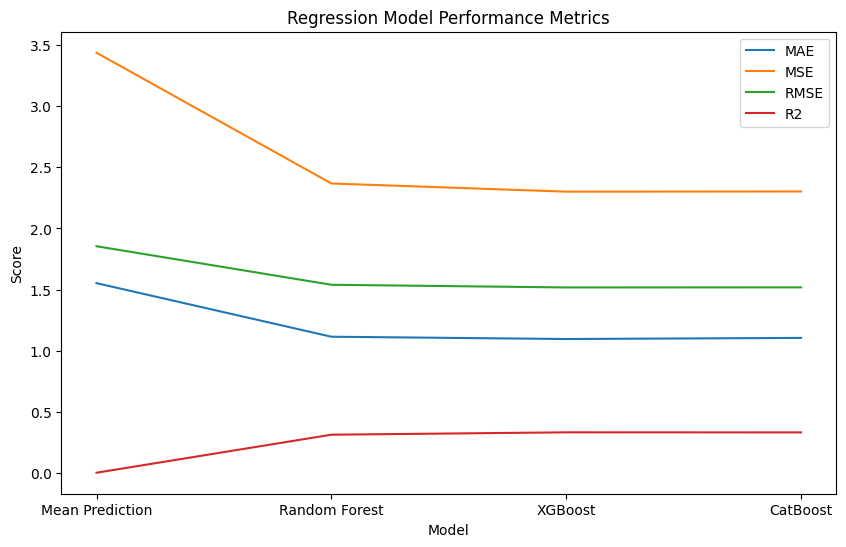

<Figure size 640x480 with 0 Axes>

In [6]:
# Prepare data for plotting
plot_data = {metric: [scores[model][metric] for model in names] for metric in metrics}

# Plot
plt.figure(figsize=(10, 6))
for metric, values in plot_data.items():
    plt.plot(names, values, label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Regression Model Performance Metrics')
plt.legend()
plt.show()

plt.savefig('output/gridsearch-all-performance.png', dpi=300)

## Test best model

In [37]:
test = pd.read_csv('data/processed/test_eng.csv')
y_test = test['severity_score']
X_test = test.drop(columns='severity_score', axis=1)

In [39]:
# training on whole train data set
final = SklearnXGBRegressor(learning_rate=0.1, max_depth=6,n_estimators=200, subsample=1.0)

final.fit(X_train, y_train)
y_pred = final.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R2 Score:", r2)

header = '| Model | MAE | MSE | RMSE | R2 |\n'
header += '|-------|-----|-----|------|-----|\n'
header += f'| XGBoost | {mae} | {mse} | {rmse} | {r2}| \n' 

print(header)

Mean Squared Error: 2.313652809469206
Mean Absolute Error: 1.094553692901747
Root Mean Squared Error: 1.5210696267657198
R2 Score: 0.32571620264769907
| Model | MAE | MSE | RMSE | R2 |
|-------|-----|-----|------|-----|
| XGBoost | 1.094553692901747 | 2.313652809469206 | 1.5210696267657198 | 0.32571620264769907| 



# K Selection data set

In [43]:
train = pd.read_csv('data/processed/train_ksel.csv', index_col=0)

y_train = train['severity_score']
X_train = train.drop(columns='severity_score', axis=1)

## Grid Search

In [44]:
# Define models
models = {
    'XGBoost': SklearnXGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42),
    'CatBoost': CatBoostRegressor(iterations=1000, learning_rate=0.05, depth=10, verbose=200)
}

names = ['Mean Prediction', 'XGBoost', 'CatBoost']

# Dictionary to store scores
metrics = ['MAE', 'MSE', 'RMSE', 'R2']
scores_ksel = {model_name: {metric: [] for metric in metrics} for model_name in names}

scoring = {
    'MAE': make_scorer(mean_absolute_error, greater_is_better=False),
    'MSE': make_scorer(mean_squared_error, greater_is_better=False),
    'R2': 'r2'
}

# Mean prediction as baseline model
mean_value = np.mean(y_train)
mean_predictions = np.full_like(y_train, mean_value)

# Store baseline model metrics
scores_ksel['Mean Prediction']['MAE'] = mean_absolute_error(y_train, mean_predictions)
scores_ksel['Mean Prediction']['MSE'] = mean_squared_error(y_train, mean_predictions)
scores_ksel['Mean Prediction']['RMSE'] = np.sqrt(mean_squared_error(y_train, mean_predictions))
scores_ksel['Mean Prediction']['R2'] = r2_score(y_train, mean_predictions)

# Hyperparameter grids for GridSearchCV
param_grids = {
    'XGBoost': {
        'n_estimators': [100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 6, 10],
        'subsample': [0.7, 0.8, 1.0]
    },
    'CatBoost': {
        'iterations': [500, 1000],
        'learning_rate': [0.05, 0.1],
        'depth': [6, 10, 12],
        'l2_leaf_reg': [1, 3, 5],
    }
}

# Perform Grid Search and Cross-Validation for each model
for model_name, model in models.items():
    print(f'\nPerforming Grid Search for {model_name}...')

    # Set the parameter grid for the model
    param_grid = param_grids[model_name]

    # Grid Search with Cross-Validation
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring['R2'], cv=5, n_jobs=-1, verbose=1, refit=True)

    # Fit GridSearchCV to the training data
    grid_search.fit(X_train, y_train)

    # Best estimator after grid search
    best_model = grid_search.best_estimator_

    # Save the best model using joblib
    joblib.dump(best_model, f'output/grid_{model_name}_best_model_ksel.pkl')
    print(f'Best model for {model_name} saved as grid_{model_name}_best_model_ksel.pkl')

    # Get the best score and parameters
    best_score = grid_search.best_score_
    best_params = grid_search.best_params_

    print(f"Best R2 score for {model_name}: {best_score:.4f}")
    print(f"Best parameters for {model_name}: {best_params}")

    # Get the cross-validation results for the best model
    cv_results = cross_validate(best_model, X_train, y_train, cv=5, scoring=scoring, return_train_score=False)
    
    # Store the scores for this model
    scores_ksel[model_name]['MAE'] = -np.mean(cv_results['test_MAE'])  # Negate for negative MAE
    scores_ksel[model_name]['MSE'] = -np.mean(cv_results['test_MSE'])  # Negate for negative MSE
    scores_ksel[model_name]['RMSE'] = np.sqrt(scores[model_name]['MSE'])
    scores_ksel[model_name]['R2'] = np.mean(cv_results['test_R2'])

# Print scores
for model_name, metrics in scores_ksel.items():
    print(f'\n{model_name}:')
    for metric, value in metrics.items():
        print(f'{metric}: {value:.4f}')


Performing Grid Search for XGBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits


/Users/phil/.local/share/virtualenvs/road-accidents-7g6MBnMk/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best model for XGBoost saved as grid_XGBoost_best_model_ksel.pkl
Best R2 score for XGBoost: 0.3296
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 200, 'subsample': 0.8}

Performing Grid Search for CatBoost...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
0:	learn: 1.8341382	total: 65.1ms	remaining: 32.5s
200:	learn: 1.5347774	total: 2.9s	remaining: 4.31s
400:	learn: 1.5121303	total: 5.46s	remaining: 1.35s
499:	learn: 1.5042431	total: 6.69s	remaining: 0us


/Users/phil/.local/share/virtualenvs/road-accidents-7g6MBnMk/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


0:	learn: 1.8286708	total: 69.9ms	remaining: 34.9s
200:	learn: 1.5273987	total: 2.74s	remaining: 4.07s
400:	learn: 1.5045495	total: 5.14s	remaining: 1.27s
499:	learn: 1.4967169	total: 6.44s	remaining: 0us
0:	learn: 1.8272993	total: 17.9ms	remaining: 8.93s
200:	learn: 1.5312239	total: 2.6s	remaining: 3.87s
400:	learn: 1.5091946	total: 4.86s	remaining: 1.2s
499:	learn: 1.5015228	total: 6s	remaining: 0us
0:	learn: 1.8341845	total: 11.7ms	remaining: 5.82s
200:	learn: 1.5358484	total: 2.43s	remaining: 3.62s
400:	learn: 1.5138954	total: 4.89s	remaining: 1.21s
499:	learn: 1.5066270	total: 6.11s	remaining: 0us
0:	learn: 1.8069196	total: 11ms	remaining: 5.5s
200:	learn: 1.5060303	total: 2.34s	remaining: 3.48s
400:	learn: 1.4816606	total: 4.83s	remaining: 1.19s
499:	learn: 1.4719824	total: 6.09s	remaining: 0us
0:	learn: 1.8104347	total: 10ms	remaining: 9.99s
200:	learn: 1.5076498	total: 2.39s	remaining: 9.51s
400:	learn: 1.4807354	total: 4.67s	remaining: 6.98s
600:	learn: 1.4611054	total: 6.87s	

In [45]:
# Generate the markdown table and save to file
markdown_table = scores_to_markdown(scores_ksel)
with open('output/gridsearch_model_scores_ksel.md', 'w') as f:
    f.write(markdown_table)

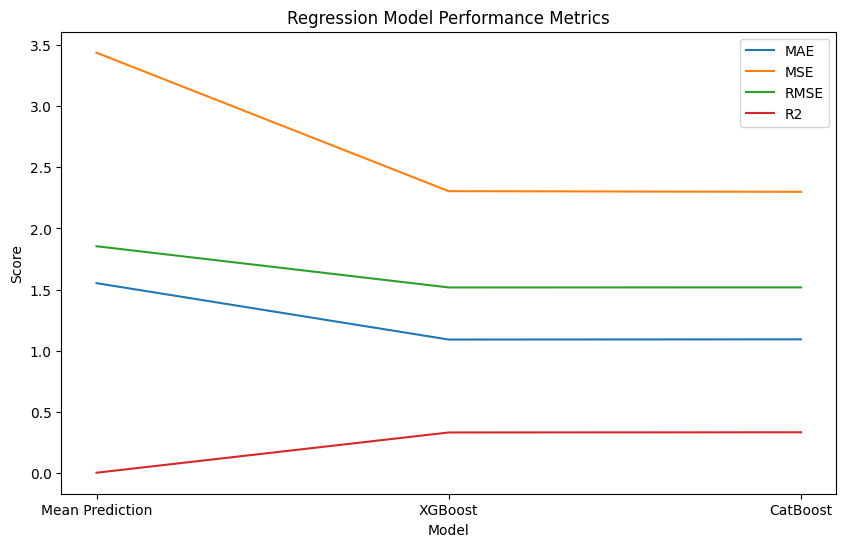

<Figure size 640x480 with 0 Axes>

In [46]:
# Prepare data for plotting
plot_data = {metric: [scores_ksel[model][metric] for model in names] for metric in metrics}

# Plot
plt.figure(figsize=(10, 6))
for metric, values in plot_data.items():
    plt.plot(names, values, label=metric)

plt.xlabel('Model')
plt.ylabel('Score')
plt.title('Regression Model Performance Metrics')
plt.legend()
plt.show()

plt.savefig('output/gridsearch-ksel-performance.png', dpi=300)

## Test best model

In [49]:
test = pd.read_csv('data/processed/test_ksel.csv', index_col=0)
y_test = test['severity_score']
X_test = test.drop(columns='severity_score', axis=1)

In [52]:
# training on whole train data set
final = CatBoostRegressor(learning_rate=0.1, depth=6, n_estimators=1000, l2_leaf_reg=5)

final.fit(X_train, y_train)
y_pred = final.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("Root Mean Squared Error:", rmse)
print("R2 Score:", r2)

header = '| Model | MAE | MSE | RMSE | R2 |\n'
header += '|-------|-----|-----|------|-----|\n'
header += f'| CatBoost | {mae} | {mse} | {rmse} | {r2}| \n' 

print(header)

0:	learn: 1.8105411	total: 4.62ms	remaining: 4.62s
1:	learn: 1.7738209	total: 13.4ms	remaining: 6.67s
2:	learn: 1.7428264	total: 17.6ms	remaining: 5.83s
3:	learn: 1.7188916	total: 21ms	remaining: 5.23s
4:	learn: 1.6969017	total: 24.5ms	remaining: 4.87s
5:	learn: 1.6782050	total: 28.2ms	remaining: 4.67s
6:	learn: 1.6633480	total: 31.9ms	remaining: 4.53s
7:	learn: 1.6510678	total: 35.1ms	remaining: 4.35s
8:	learn: 1.6390852	total: 38.5ms	remaining: 4.24s
9:	learn: 1.6292481	total: 41.9ms	remaining: 4.14s
10:	learn: 1.6210340	total: 44.9ms	remaining: 4.04s
11:	learn: 1.6139060	total: 48.3ms	remaining: 3.98s
12:	learn: 1.6070388	total: 51.7ms	remaining: 3.92s
13:	learn: 1.6014250	total: 55ms	remaining: 3.87s
14:	learn: 1.5967839	total: 58.8ms	remaining: 3.86s
15:	learn: 1.5923956	total: 62.2ms	remaining: 3.82s
16:	learn: 1.5887210	total: 65.8ms	remaining: 3.8s
17:	learn: 1.5857993	total: 68.9ms	remaining: 3.76s
18:	learn: 1.5830047	total: 72ms	remaining: 3.71s
19:	learn: 1.5801858	total: 7